In [185]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
df = pd.read_csv('covid.csv')
df

,country,region,region_code,start_date,end_date,days,year,week,population,total_deaths,covid_deaths,expected_deaths,excess_deaths,non_covid_deaths,covid_deaths_per_100k,excess_deaths_per_100k,excess_deaths_pct_change
0,Australia,Australia,0,2019-12-30,2020-01-05,7,2020,1,25921089,2926.0,0,2965.372893,-39.372893,2926.0,0.000000,-0.151895,-0.013278
1,Australia,Australia,0,2020-01-06,2020-01-12,7,2020,2,25921089,2902.0,0,2956.539560,-54.539560,2902.0,0.000000,-0.210406,-0.018447
2,Australia,Australia,0,2020-01-13,2020-01-19,7,2020,3,25921089,2914.0,0,2932.039560,-18.039560,2914.0,0.000000,-0.069594,-0.006153
3,Australia,Australia,0,2020-01-20,2020-01-26,7,2020,4,25921089,3007.0,0,2940.372893,66.627107,3007.0,0.000000,0.257038,0.022659
4,Australia,Australia,0,2020-01-27,2020-02-02,7,2020,5,25921089,2910.0,0,2900.039560,9.960440,2910.0,0.000000,0.038426,0.003435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5765,United States,United States,0,2022-05-09,2022-05-15,7,2022,19,336997624,57864.0,1868,55510.914407,2353.085593,55996.0,0.554307,0.698250,0.042390
5766,United States,United States,0,2022-05-16,2022-05-22,7,2022,20,336997624,57523.0,2461,54958.314407,2564.685593,55062.0,0.730272,0.761040,0.046666
5767,United States,United States,0,2022-05-23,2022-05-29,7,2022,21,336997624,56959.0,2607,54850.514407,2108.485593,54352.0,0.773596,0.625668,0.038441
5768,United States,United States,0,2022-05-30,2022-06-05,7,2022,22,336997624,57545.0,1956,54459.714407,3085.285593,55589.0,0.580420,0.915521,0.056653


In [186]:
df = df.dropna()
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

# Проверка данных после преобразования дат
print(df[['start_date', 'end_date']].head())

  start_date   end_date
0 2019-12-30 2020-01-05
1 2020-01-06 2020-01-12
2 2020-01-13 2020-01-19
3 2020-01-20 2020-01-26
4 2020-01-27 2020-02-02


In [179]:
print(df['region'].unique())

# Выбор региона с большим количеством данных, например США
selected_region = 'United States'
region_df = df[df['region'] == selected_region]

# Проверка на наличие данных для выбранного региона
if region_df.empty:
    raise ValueError(f"No data available for the selected region: {selected_region}")
covid_deaths_per_100k = region_df.set_index('start_date')['covid_deaths_per_100k']
print(covid_deaths_per_100k)

['Australia' 'Austria' 'Belgium' 'Britain' 'Bulgaria' 'Canada' 'Chile'
 'Colombia' 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Ecuador'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Guatemala' 'Hungary'
 'Iceland' 'Iran' 'Israel' 'Italy' 'Latvia' 'Lithuania' 'Luxembourg'
 'Malta' 'Mexico' 'Montenegro' 'Netherlands' 'New Zealand' 'Norway' 'Peru'
 'Poland' 'Portugal' 'Romania' 'Slovakia' 'Slovenia' 'South Africa'
 'South Korea' 'Spain' 'Sweden' 'Switzerland' 'Tunisia' 'United States']
start_date
2019-12-30    0.000000
2020-01-06    0.000000
2020-01-13    0.000000
2020-01-20    0.000000
2020-01-27    0.000000
                ...   
2022-05-09    0.554307
2022-05-16    0.730272
2022-05-23    0.773596
2022-05-30    0.580420
2022-06-06    0.821964
Name: covid_deaths_per_100k, Length: 128, dtype: float64


In [180]:
result = adfuller(covid_deaths_per_100k)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Приведение ряда к стационарному виду (если необходимо)
if result[1] > 0.05:
    covid_deaths_per_100k_stationary = covid_deaths_per_100k.diff().dropna()
else:
    covid_deaths_per_100k_stationary = covid_deaths_per_100k

# Проверка на наличие данных после дифференцирования
if covid_deaths_per_100k_stationary.empty:
    raise ValueError("No data available after differencing")
print(covid_deaths_per_100k_stationary.head())

# Проверка на наличие данных после дифференцирования
if covid_deaths_per_100k_stationary.empty:
    raise ValueError("No data available after differencing")

ADF Statistic: -3.587987363510501
p-value: 0.005994880308406632
start_date
2019-12-30    0.0
2020-01-06    0.0
2020-01-13    0.0
2020-01-20    0.0
2020-01-27    0.0
Name: covid_deaths_per_100k, dtype: float64


In [181]:
model = pm.auto_arima(covid_deaths_per_100k_stationary, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model.summary())

n_periods = 30
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

forecast_index = pd.date_range(start=covid_deaths_per_100k_stationary.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='D')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=187.033, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=637.476, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=200.331, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=491.645, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=191.543, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=186.177, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=193.449, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=189.848, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=187.456, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=186.935, Time=0.07 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=178.867, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=192.759, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=188.111, Time=0.07 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=180.450, 

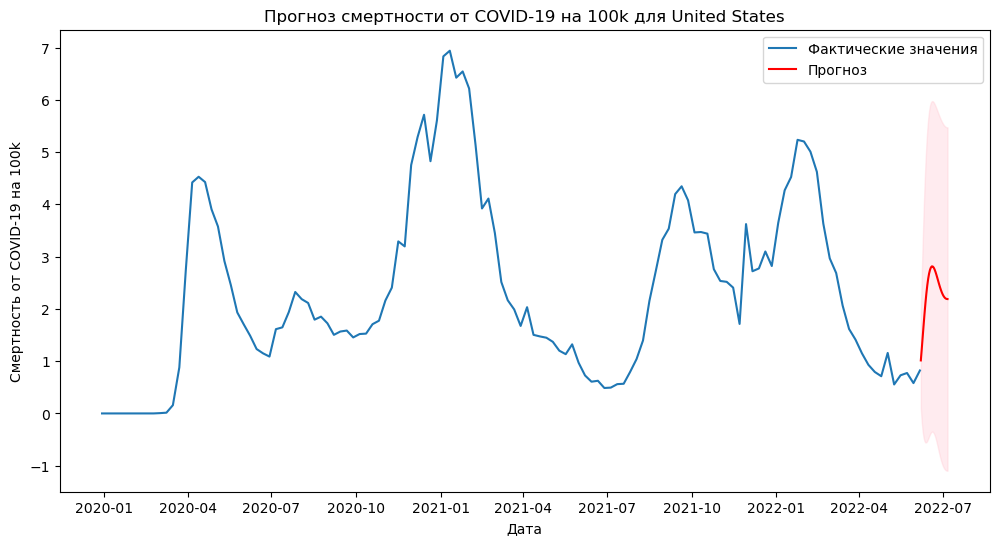

In [182]:
plt.figure(figsize=(12, 6))
plt.plot(covid_deaths_per_100k_stationary, label='Фактические значения')
plt.plot(forecast_index, forecast, label='Прогноз', color='red')
plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title(f'Прогноз смертности от COVID-19 на 100k для {selected_region}')
plt.xlabel('Дата')
plt.ylabel('Смертность от COVID-19 на 100k')
plt.show()

In [183]:
# Кросс-валидация для модели ARIMA (для сравнения в будущем)
tscv = TimeSeriesSplit(n_splits=5)
arima_scores = []

for train_index, test_index in tscv.split(covid_deaths_per_100k_stationary):
    train, test = covid_deaths_per_100k_stationary[train_index], covid_deaths_per_100k_stationary[test_index]
    model = pm.auto_arima(train, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True)
    forecast = model.predict(n_periods=len(test))
    arima_scores.append(r2_score(test, forecast))

print(f'Cross-Validation arima: {arima_scores}')
print(f'Mean Cross-Validation arima: {np.mean(arima_scores)}')

D:\Users\aomurbaeva\AppData\Local\Temp\ipykernel_4800\2691791771.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = covid_deaths_per_100k_stationary[train_index], covid_deaths_per_100k_stationary[test_index]
D:\Users\aomurbaeva\AppData\Local\Temp\ipykernel_4800\2691791771.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = covid_deaths_per_100k_stationary[train_index], covid_deaths_per_100k_stationary[test_index]
D:\Users\aomurbaeva\AppData\Local\Temp\ipykernel_4800\2691791771.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer ke

Cross-Validation arima: [-0.406087043227352, -3.1984039886431814, -2.1947987623668186, -0.7659440050702266, 0.5890588838417696]
Mean Cross-Validation arima: -1.1952349830931617
